In [1]:
import pandas as pd
import numpy as np
import gpflow
import matplotlib.pyplot as plt
import pickle

import utils as u
from models import Matern32_Model
%matplotlib inline


%load_ext autoreload
%autoreload 2

/home/ecbm4040/miniconda2/envs/dlenv/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [47]:
data = pd.read_csv('../data/gp_weekly_nta_data.csv')
data['DATETIME'] = pd.to_datetime(data['DATETIME'])

data.DATE_IND = data.DATE_IND.astype(float) / 100  # try to bring down variance scale

data.rename(columns={'INJURED':'COUNT'},inplace=True)

data.COUNT = data.COUNT.astype(float)

data = data[data.BoroName == 'Manhattan']

e_s = data.e_s.mean()

print(data.shape)

(8497, 13)


In [69]:
search_periods = [[52,12]]



Beginning run [52, 12] : 
Training ends on: 2016-01-03 00:00:00
testing ends on: 2016-03-27 00:00:00
using the safe Matern!
using the safe Matern!
Initial neg. log-likelihood: -77476.5665887
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 3565.803515
  Number of iterations: 560
  Number of functions evaluations: 612
using the safe Matern!
using the safe Matern!
using the safe Matern!
using the safe Matern!
added gp pred and error to test
gp_sq_error    6.854111
0              6.673740
dtype: float64


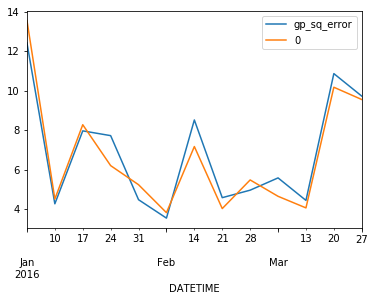

In [74]:
for i, s in enumerate(search_periods):
    
    print('Beginning run {} : '.format(str(s)))
    #print('{} periods for training \n').format(s[0])
    #print('{} periods for testing \n').format(s[1])

    data_dict = u.preprocess(data, start_date= '2015/1/04', training_end_date= s[0], \
                                                           testing_end_date=s[1])


    m =  Matern32_Model(data_dict['X_train'],data_dict['y_train'],use_priors=True, e_s = e_s , period = 0.52)
    m.compile()
    opt = gpflow.train.ScipyOptimizer()
    print('Initial neg. log-likelihood: {}'.format(str(m.compute_log_likelihood())))
    opt.minimize(m, maxiter = 800)
    
    u.pred_GP(m,data_dict)
    test = data_dict['test']

    gp = test.groupby('DATETIME')['gp_sq_error'].mean() #/ test.GRID_SQUARE.max()
    ar = u.run_AR(data_dict)
    ar = ar 
    summary = pd.concat([gp,ar],axis=1)
    summary.plot()

    print(summary.mean())


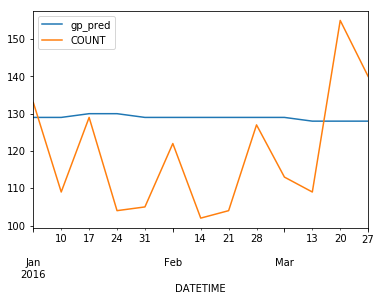

In [75]:
test.groupby('DATETIME')[['gp_pred','COUNT']].sum().plot()


In [72]:
m.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
VGP/q_sqrt,Parameter,None,LoTri->vec,True,"(1, 1537, 1537)",True,"[[[0.103370159066, 0.0, 0.0, 0.0, 0.0, 0.0, 0...."
VGP/q_mu,Parameter,None,(none),True,"(1537, 1)",True,"[[-1.0849441587], [0.450030281356], [-0.169038..."
VGP/kern/safematern32/lengthscales,Parameter,"student-T([ 0.],[ 1.][ 4.])",+ve,True,(),True,0.42403914778658075
VGP/kern/safematern32/variance,Parameter,"student-T([ 0.],[ 1.][ 4.])",+ve,True,(),True,0.2788893709434911
VGP/kern/safematern32/lengthscales,Parameter,"student-T([ 0.],[ 1.][ 4.])",+ve,True,(),True,0.42403914778658075
VGP/kern/safematern32/variance,Parameter,"student-T([ 0.],[ 1.][ 4.])",+ve,True,(),True,0.2788893709434911
VGP/kern/rbf/lengthscales,Parameter,"student-T([ 0.],[ 1.][ 4.])",+ve,True,(),True,0.8602880838188495
VGP/kern/rbf/variance,Parameter,"student-T([ 0.],[ 1.][ 4.])",+ve,True,(),True,0.5527595971207395
VGP/kern/rbf/lengthscales,Parameter,"student-T([ 0.],[ 1.][ 4.])",+ve,True,(),True,0.8602880838188495
VGP/kern/rbf/variance,Parameter,"student-T([ 0.],[ 1.][ 4.])",+ve,True,(),True,0.5527595971207395


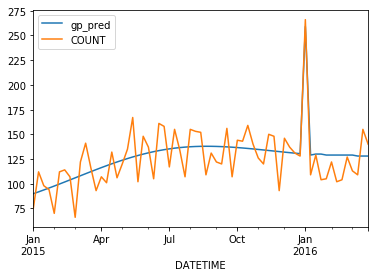

In [76]:
pred_train = m.predict_y(data_dict['X_train'])
train = data_dict['train']
train['gp_pred'] = pred_train[0]
test = data_dict['test']
train.append(test).groupby("DATETIME")['gp_pred','COUNT'].sum().plot()



## This needs:
# train/test normalization has to be split
# prediction has to be done right when looking ahead (sequentially)


In [17]:
ar

DATETIME
2015-01-04    10.071618
2015-01-11     8.198939
2015-01-18     9.679045
2015-01-25     8.222812
2015-02-01    13.151194
2015-02-08     5.591512
2015-02-15     6.846154
2015-02-22     3.785146
2015-03-01     9.694960
2015-03-08     8.183024
2015-03-15    14.604775
2015-03-22     7.092838
2015-03-29     8.342175
dtype: float64

In [13]:
np.square(test.gp_pred - test.COUNT).groupby('DATETIME').mean()

DATETIME
2015-01-04     6.965517
2015-01-11     6.827586
2015-01-18     5.379310
2015-01-25     4.896552
2015-02-01     7.517241
2015-02-08     3.103448
2015-02-15     5.586207
2015-02-22     3.137931
2015-03-01     5.206897
2015-03-08     6.448276
2015-03-15    13.000000
2015-03-22     5.103448
2015-03-29     4.551724
dtype: float64

In [ ]:

output = pd.DataFrame(index=test.index, columns=['pred','seed'])

output.ix[0,'seed'] = m.predict_f([data_dict['X_train'][-1]])[0]

for i in range(output.shape[0]):
    output.ix[i+1,'pred'] = m.predict_y([output.ix[0,'seed'][0]])


                                       
    if i > 0:
        m.predict_f([output.ix[i,'seed']])[0]

output


In [ ]:
## Missing data 2016

data.groupby('DATETIME')['COUNT'].sum().plot()

In [ ]:
test.groupby('GRID_SQUARE')['COUNT'].sum().sort_values(ascending = False).head()

In [ ]:
test[test.GRID_SQUARE == 108][['gp_pred','COUNT']].plot()